# Frontend


<table style="border: solid #fff;">
<!--  Website to generate base63 stream : https://www.base64-image.de/
-->    
    <tr style="vertical-align:top"><td style="vertical-align:top">
        <p style="font-size: 110%;">On the right you see the screenshot during the card drop process in action.</p>
        <ol>
        <li style="font-size: 110%;">The Frame window shows in general the current scanned image</li>
        <li style="font-size: 110%;">The light green shows the boundingbox and the bigest found contour</li>
        <li style="font-size: 110%;">The trackbars rr, gg, bb allow some calibration for red, green and blue color channel. The value 127 is th center for the correction</li>
        <li style="font-size: 110%;">Within the frame window you can see the current predicted card name</li>        
        <li style="font-size: 110%;">Within the frame window you can see the current choosen mode and also the summarized score value</li>
        <li style="font-size: 110%;">The mask window shows the current mask that will be applied to the frame</li>
        <li style="font-size: 110%;">The mask window shows the trackbar for the threshold value that will be used</li>
        <li style="font-size: 110%;">The combined window shows the combination of calibrated image, with applied mask and deep black background</li>
        <li style="font-size: 110%;">The small ml window shows the image which is going to be used on the machine learning algorythm, It has the needed input size of the current algorithm and is cropped. You can also see that surrounding black parts have been changed by the current diffuser settings</li>
        </ol>
        </td>
        <td>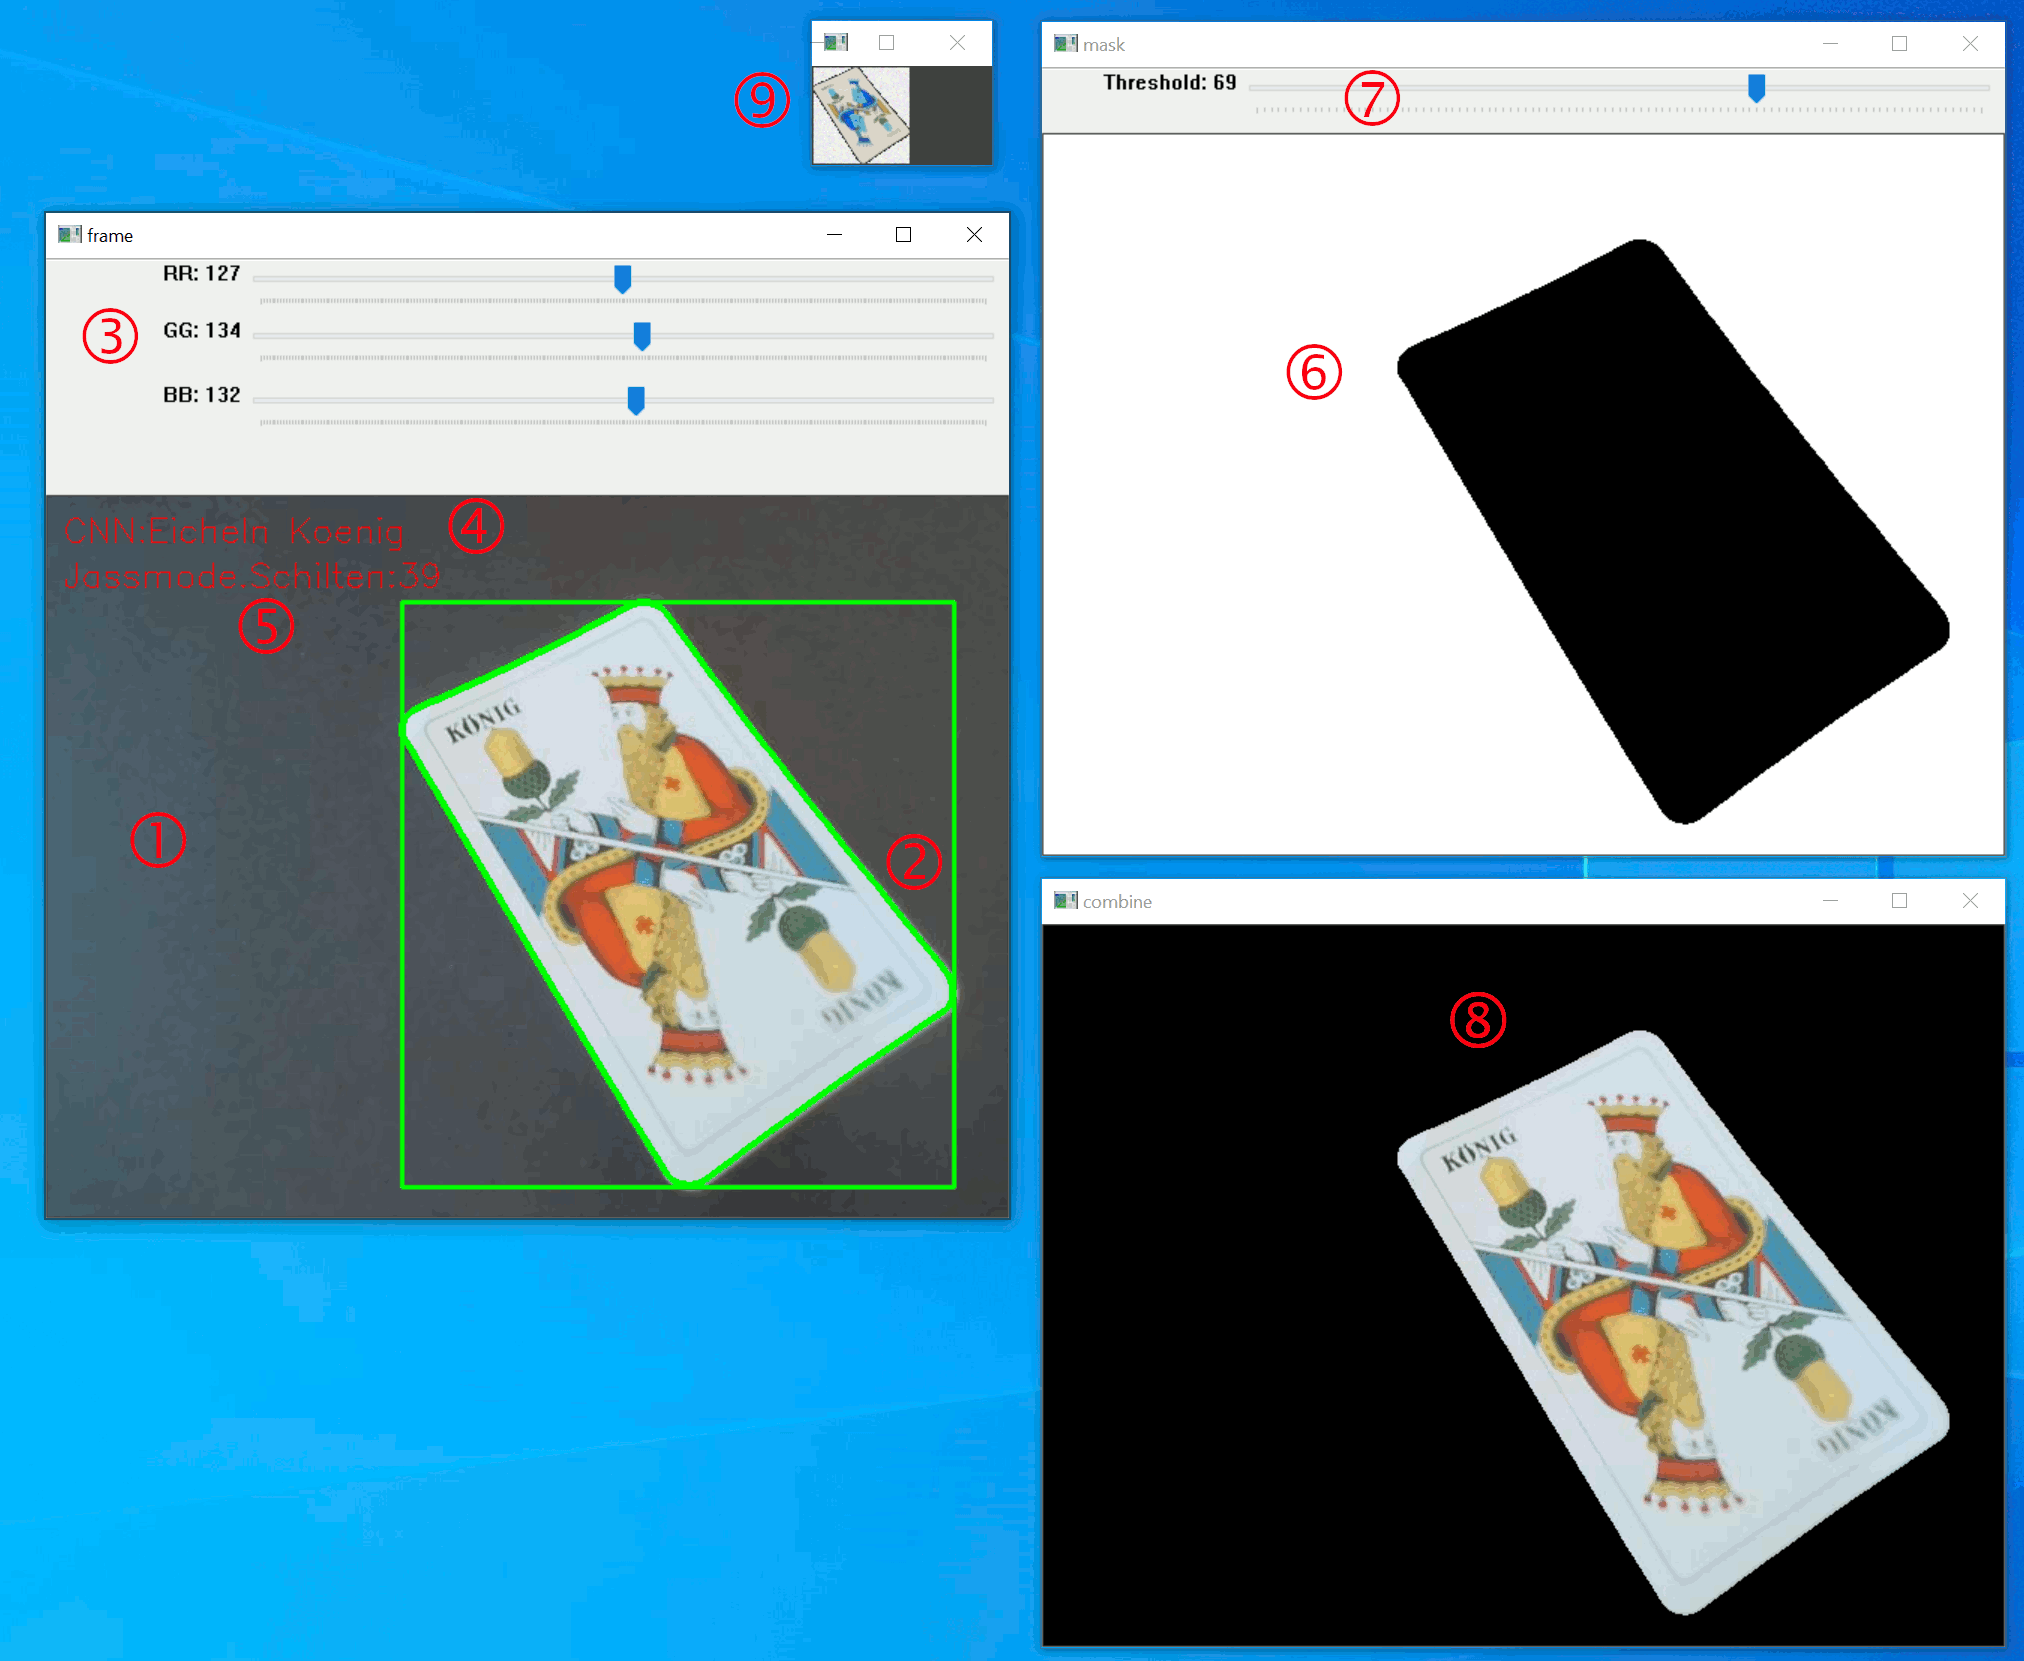</td>
    </tr></table>

In [1]:
import JassSummarizer as js
from enum import Enum
from PIL import Image
import matplotlib.pyplot as plt 
from IPython.core.display import display, HTML
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time
import re
import cv2
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.models import Sequential,model_from_json
from PIL import Image

modelname="CIFA64_diffuser_model"                                                                  # name current model to use
modelname="CNN224MA_ii_99"
modelname="CNN64_iiiiiiv_40"
modelname="test64"
modelname="CNN224_iii_99"
modelname="CNN64MA_v_40"
path=os.path.join(r".\model_save",modelname)                                                       # generate path with modelname
json_file = open(path+'.json', 'r')                                                                # open model file
loaded_model_json = json_file.read()                                                               # load file
json_file.close()                                                                                  # close file
loaded_model = model_from_json(loaded_model_json)                                                  # convert json object
loaded_model.load_weights(path+".h5")                                                              # load weights
print(f"Loaded model '{modelname}' from disk")                                                     # print model name
model=loaded_model                                                                                 # use general model variable wich loaded 
mode=int(re.findall(r'\d+',modelname)[0])                                                          # find size of model
inputSize = (mode, mode)                                                                           # use founded size as inputSize
mlDimension = (mode,mode,3)                                                                        # also with color chanel dimension


Loaded model 'CNN64MA_v_40' from disk


### Mobilenet Pretrained Net model initialisation

In [2]:
# Step 2
img_graph = tf.Graph()                                                                             # Create graph
with img_graph.as_default():
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'         # library url
    feature_extractor = hub.Module(module_url)                                                     # Download module
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])                       # Create input placeholder
    imgs_features = feature_extractor(input_imgs)                                                  # A node with the features
    init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])               # Collect initializers
img_graph.finalize()                                                                               # Good practice: make the graph "read-only"

initialization_op = tf.global_variables_initializer()                                              # Init
sess = tf.Session(graph=img_graph)                                                                 # Create a session
sess.run(init_op)                                                                                  # Initialize it
#features = sess.run(imgs_features, feed_dict={input_imgs: img_batch})  

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Randomforest model activation

In [3]:
import sklearn.externals.joblib as joblib
rmfFilename=r".\model_save\RMF224PT_iii_40.joblib"                                                 # define name
rmfModel = joblib.load(rmfFilename)                                                                # load trained model from Jupyter Notebook 04_Machine_learning_03


### Frontend routine for prediction

In [4]:

def nothing(val):                                                       # empty funtion to handle trackbar
    pass
def calcK(x):
    return ((127-x)*0.01)+1.0

t_rescaled=0.4
threshold=47                                                            # variable for trackbar threshold
window_name_mask="mask"                                                 # Window title name set to mask
cv2.namedWindow(window_name_mask)                                       # activate Window                
trackbar_name = "Threshold"                                             # set trackbar name          
cv2.createTrackbar(trackbar_name, "mask" , threshold, 100, nothing)             # initiate window with range from 0 -100 for threshold
predictModel="CNN"                                                      # Selector for active predict model can be CNN or RMF

r=rr=rrr=g=gg=ggg=b=bb=bbb=127                                          # r g b calibration variable, currently only rr,gg,bb is used for correction
cv2.namedWindow('frame')                                                # the window has to be named for the trackbar identification
cv2.createTrackbar('RR','frame',rr,255,nothing)                         # get value correction for red chanel
cv2.createTrackbar('GG','frame',gg,255,nothing)                         # get value correction for green chanel
cv2.createTrackbar('BB','frame',bb,255,nothing)                         # get value correction for blue chanel

# initilizing vars needed during webcam loop
savePrediction=lastPrediction=""                                        # prediction vars to validate successfull prediction behin each other
cardScore = cnt = 0                                                     # cardScore counter
jassMode = mlData2 = None                                               # has to be initialized to none, because mostly the first scan has no contours

cap = cv2.VideoCapture(0)                                               # webcam capture method 0 primary cam, 1 secondary cam
while(1):                                                               # loop until esc key
    # Take each frame
    _, frameData = cap.read()                                               # take frame
    
    rr = cv2.getTrackbarPos('RR','frame')                               # read current trackbar value for red
    gg = cv2.getTrackbarPos('GG','frame')                               # read current trackbar value for green
    bb = cv2.getTrackbarPos('BB','frame')                               # read current trackbar value for blue
    t_rescaled=cv2.getTrackbarPos(trackbar_name,'mask')*0.01            # read current trackbar value for threshold
    
    frameCalib=frameData.copy()
    frame=(frameCalib*([calcK(rr),calcK(gg),calcK(bb)])).astype("uint8")
    
    frameOrg,mask,img_rect,res,crop_img,d = js.analyzeScan(frame,t_rescaled)       # analyze image and receive diffrent result images including boundingbox dimension
    x,y,w,h = d                                                         # needed to find out if there have been contours in the analyzeScan operation
    
    if (w!=0 and h!=0):                                                 # if no contours are there we do not need to analyze something  
        rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)                 # color channel switch to RGB
        mlData1=cv2.resize(rgb, inputSize , interpolation = cv2.INTER_AREA)
        mlData2=js.backgroundDiffuser3(mlData1,10)                      # change black regions with backgroundDiffuserX function
        mlData2=mlData1                                                 # may undo backgroundDiffuserX
        #tst=[]                                                          
        mlData3=mlData2/255                                             # normalize
        scan=np.expand_dims(mlData3,axis=0)                             # add dimension for multiple prediction
        if predictModel == "RMF":                                       # check which predictionModel is active
            features = sess.run(imgs_features, feed_dict={input_imgs: scan})
            rmfPredict=rmfModel.predict(features)                       # get predicted label
            scoreId=js.JassCN2[rmfPredict[0]].value                     # get number from label
        else:                                                           # CNN mode
            score = model.predict(scan)                                 # get score array
            scoreId=score.argmax()                                      # get best score
        theCardText=js.jassCardName(js.JassCN2(scoreId).name)           # generate caredname from CardId
    else:
        theCardText=""                                                  # empty cardtext when no boundingbox is available
    
    # Display Textinformation within image
    #img_rect=cv2.putText(np.array(img_rect),theCardText, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0,0,255])
    #img_rect=cv2.putText(np.array(img_rect),str(savePrediction), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0,0,255])
    img_rect=cv2.putText(np.array(img_rect),f"{predictModel}:{lastPrediction}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0,0,255])
    img_rect=cv2.putText(np.array(img_rect),f"{jassMode}:{cardScore}", (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0,0,255])
    
    if mlData2 is not None:                                              # check if prediction is available
        cv2.imshow('ml',mlData2)                                         # show imagedata that goes into model prediction
    cv2.imshow('combine',res)                                            # show combination os mask and image
    cv2.imshow('frame',img_rect)                                         # show what was scanned
    cv2.imshow(window_name_mask,np.array(mask))                          # show mask with slider
    
    k = cv2.waitKey(3) & 0xFF                                            # wait for keystroke or continue after 3 milliseconds
    
    if lastPrediction==theCardText and theCardText!="":                  # check if there is a prediction made and if the current is equal to the last
        cnt=cnt+1                                                        # count identical predictions
        if cnt>11 and lastPrediction!=savePrediction:                    # if equal prediction count > 11 it counts as valid
            savePrediction=lastPrediction                                # update last validated prediction
            import winsound                                              # signalize accepted prediction
            duration = 30                                                # milliseconds
            freq = 1440                                                  # Hz
            winsound.Beep(freq, duration)                                # os function for sound play
            card=js.JassCN2(score.argmax()).name                         # get score
            if jassMode is not None:                                     # calculate if jassMode ist set
                cardScore = cardScore + (js.calculateScore(card,jassMode))
    else:
        cnt=0                                                            # reset count if there was another prediction then the last
    lastPrediction=theCardText                                           # update text
            
    if k==49:      # 1
        cardScore=0; jassMode=js.Jassmode.Eicheln
    if k==50:      # 2
        cardScore=0; jassMode=js.Jassmode.Schellen
    if k==51:      # 3
        cardScore=0; jassMode=js.Jassmode.Schilten
    if k==52:      # 4
        cardScore=0; jassMode=js.Jassmode.Rosen
    if k==53:      # 5
        cardScore=0; jassMode=js.Jassmode.Topdown    
    if k==54:      # 6
        cardScore=0; jassMode=js.Jassmode.Downup         
    if k == 32:      # Space
        cardScore=0
    if k == 48:      # 0 => switch to RMF pretrained mode
        inputSize=(224,224)
        predictModel="RMF"
    if k == 27:                                                           # Escape key check for exit
        myImg=Image.fromarray(mlData2)
        myImg.save("last.jpg")
        break
        
cv2.destroyAllWindows()

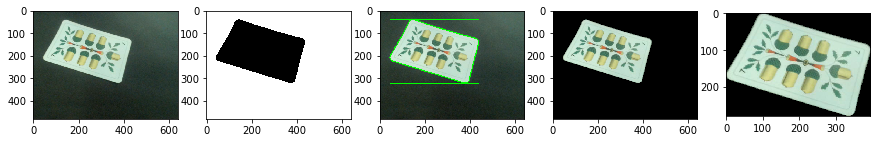

In [5]:
visualCheck= True
if visualCheck:
    data=js.analyzeScan(frameOrg)
    display(HTML("<h1>analyzeImage result check"))
    fig=plt.figure(figsize=(15,15))
    i=col=1
    for item in data[0:-1]:
        temp=cv2.cvtColor(item,cv2.COLOR_BGR2RGB)
        fig.add_subplot(1, 5, i)
        plt.imshow(temp)
        i=i+1
    plt.show()

array(['C1'], dtype=object)

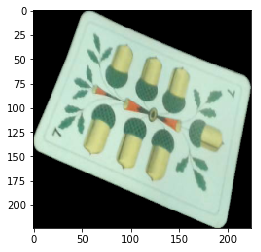

In [6]:

rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
mlData1=cv2.resize(rgb, (224,224) , interpolation = cv2.INTER_AREA)
features = sess.run(imgs_features, feed_dict={input_imgs: np.expand_dims(mlData1, axis=0)})
plt.imshow(mlData1)
rmfModel.predict(features)

In [7]:
predictModel

'CNN'